In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# BeautyGAN

## Library import & Drive mount

In [ ]:
# DIP 라이브러리 (Face detection, Landmark detection, Face alignment)
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import numpy as np

## Load Images

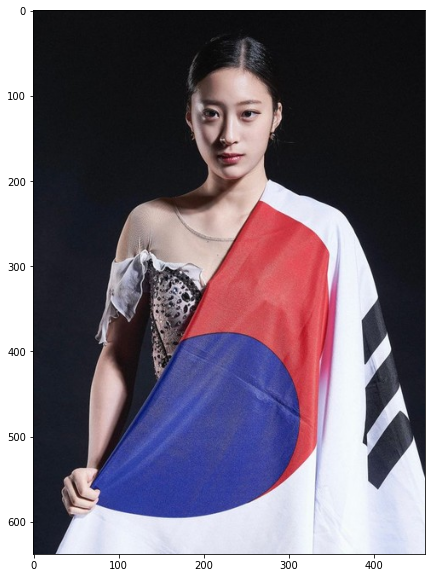

In [ ]:
img = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/Olympic_imgs/유영.jfif')
plt.figure(figsize=(16, 10))
plt.imshow(img)

## Face Detection

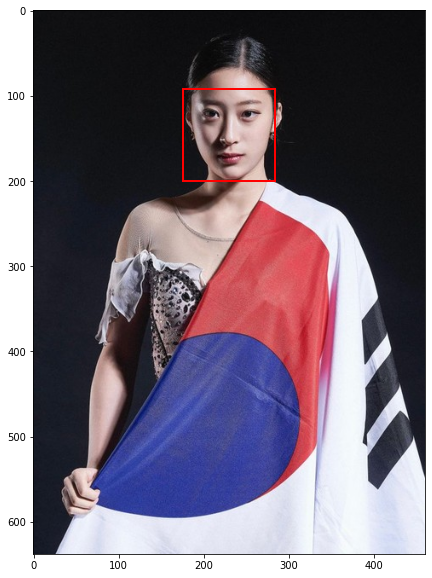

In [ ]:
img_result = img.copy()

detector = dlib.get_frontal_face_detector() # 얼굴 영역 인식 모델 로드
dets = detector(img, 1) # 이미지에서 얼굴 영역 찾기

# 얼굴 영역의 개수가 0일 경우
if len(dets) == 0:
    print('cannot find faces!')

fig, ax = plt.subplots(1, figsize=(16, 10))

# 얼굴 찾으면 -> det : rectangle object
for det in dets:
    x, y, w, h = det.left(), det.top(), det.width(), det.height()
    rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none') # 직사각형 그리기
    ax.add_patch(rect) # 그래프 영역에 패치 추가
    
ax.imshow(img_result)

## Landmark Detection 
#### 5 points (Face Detection 한 부분에서 눈 양쪽 끝과 코 끝)

In [ ]:
# 5점 랜드마크 찾는 모델 로드
sp = dlib.shape_predictor('/content/drive/MyDrive/BeautyGAN-master/models/shape_predictor_5_face_landmarks.dat')

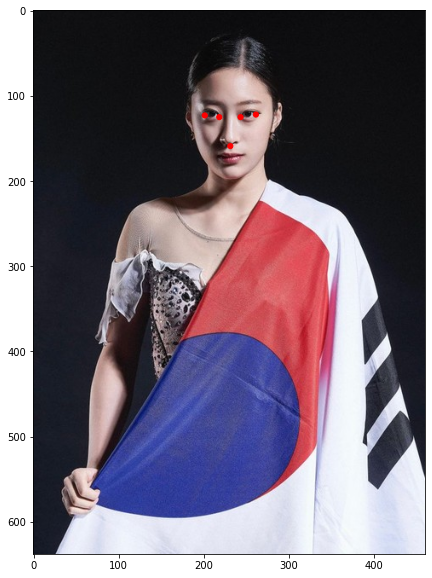

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 10))

objs = dlib.full_object_detections() # 얼굴 수평 맞춰주기 위해 사용할 인스턴스

for detection in dets:
    s = sp(img, detection) # 위에서 로드했던, 얼굴의 랜드마크 찾는 모델에 img와 rectangle 위치 넣어줌
    objs.append(s)
    
    for point in s.parts(): # 5점이니까 for문 5번 반복
        circle = patches.Circle((point.x, point.y), radius=3, edgecolor='r', facecolor='r')
        ax.add_patch(circle)

ax.imshow(img_result)

## Face Alignment
#### 5개 랜드마크를 기준으로 얼굴의 수평 맞춰주기

In [ ]:
# 원본 이미지 입력하면 crop 및 align 된 얼굴 이미지 반환

def align_faces(img):

    dets = detector(img, 1) # dectector 이용해서 이미지에서 얼굴 영역 찾기
    
    objs = dlib.full_object_detections() # 얼굴 수평 맞추기 위해 사용할 모델 인스턴스

    for detection in dets:
        s = sp(img, detection) # 얼굴의 랜드마크 찾는 모델에 img와 rectangle 위치 넣어줌
        objs.append(s)

    # 얼굴을 수평으로 회전해 얼굴 부분만 자른 이미지 반환, padding 작게 주면 타이트하게 자름
    faces = dlib.get_face_chips(img, objs, size=256, padding=0.35)
    
    return faces

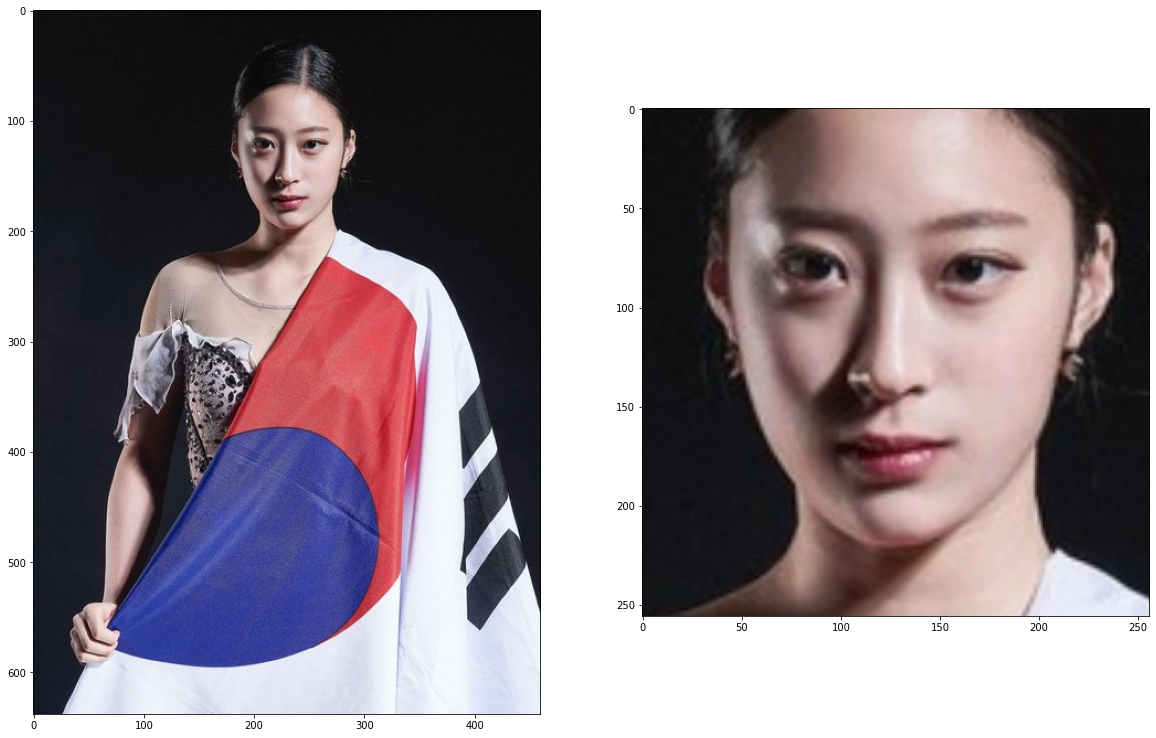

In [ ]:
# test
test_faces = align_faces(img)

fig, axes = plt.subplots(1, len(test_faces)+1, figsize=(20, 16))
axes[0].imshow(img)

for i, face in enumerate(test_faces):
    axes[i+1].imshow(face)

## Load BeautyGAN Pretrained
- https://drive.google.com/drive/folders/1pgVqnF2-rnOxcUQ3SO4JwHUFTdiSe5t9

In [ ]:
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.compat.v1.disable_eager_execution()

In [ ]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())

    sess = tf.compat.v1.Session()
    saver = tf.compat.v1.train.import_meta_graph('/content/drive/MyDrive/BeautyGAN-master/models/model.meta')
    saver.restore(sess, tf.compat.v1.train.latest_checkpoint('/content/drive/MyDrive/BeautyGAN-master/models'))
    graph = tf.compat.v1.get_default_graph()

    X = graph.get_tensor_by_name('X:0') # source (no makeup img)
    Y = graph.get_tensor_by_name('Y:0') # reference (makeup img)
    Xs = graph.get_tensor_by_name('generator/xs:0') # output (generator가 만든 img)

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/BeautyGAN-master/models/model


## Preprocess and Postprocess Functions

In [ ]:
# uint8(0~255) -> float32(-1~1)
def preprocess(img):
    return img.astype(np.float32) / 127.5 - 1.

# float32(-1~1) -> uint8(0~255)
def postprocess(img):
    return ((img + 1.) * 127.5).astype(np.uint8)

# Start

## Load Images

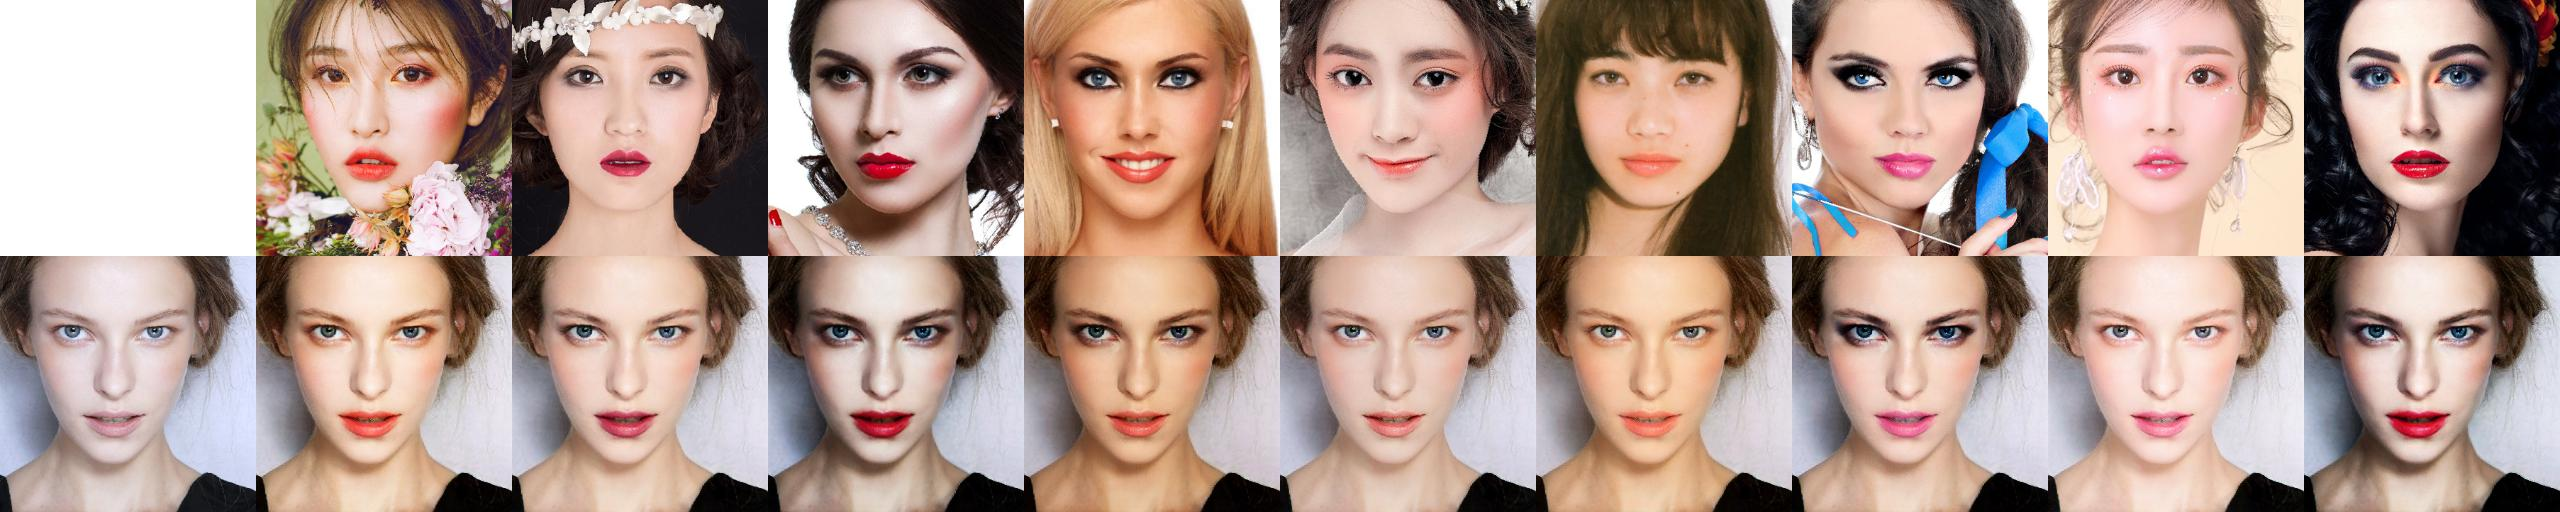

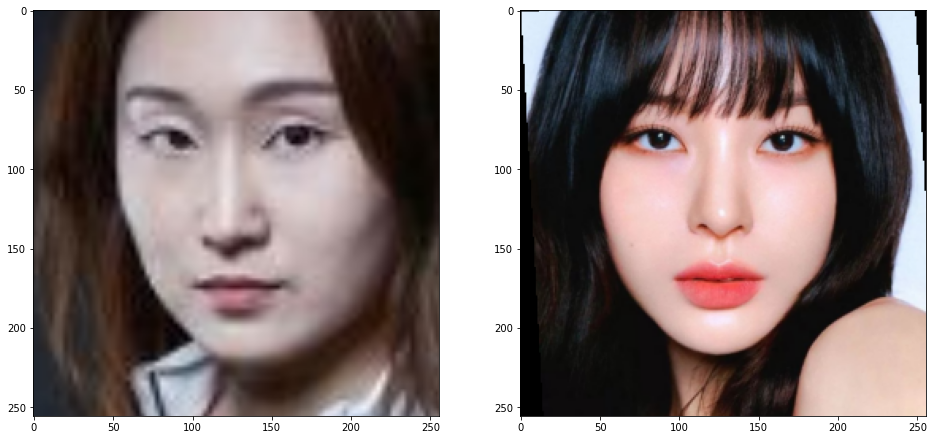

In [ ]:
img1 = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/Olympic_imgs/최민정3.jfif') # source
img1_faces = align_faces(img1)

img2 = dlib.load_rgb_image('/content/drive/MyDrive/BeautyGAN-master/imgs/makeup/NJ_makeup.jpg') # reference
img2_faces = align_faces(img2)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))
axes[0].imshow(img1_faces[0])
axes[1].imshow(img2_faces[0])

## Run

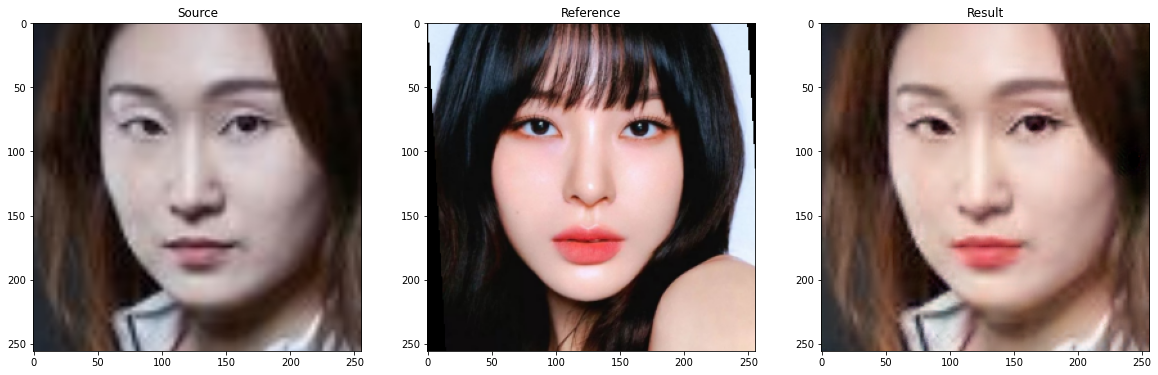

In [ ]:
src_img = img1_faces[0]
ref_img = img2_faces[0]

X_img = preprocess(src_img)              # array(256,256,3)
X_img = np.expand_dims(X_img, axis=0)    # array(1,256,256,3)

Y_img = preprocess(ref_img)
Y_img = np.expand_dims(Y_img, axis=0)

output = sess.run(Xs, feed_dict={
    X: X_img,
    Y: Y_img
})

output_img = postprocess(output[0])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].set_title('Source')
axes[0].imshow(src_img)
axes[1].set_title('Reference')
axes[1].imshow(ref_img)
axes[2].set_title('Result')
axes[2].imshow(output_img)

## Image save

In [ ]:
from PIL import Image
im = Image.fromarray(output_img)
im.save('/content/BeautyGAN_result.png','png')

# SRGAN

In [ ]:
!git clone https://github.com/mseitzer/srgan.git

fatal: destination path 'srgan' already exists and is not an empty directory.


In [ ]:
cd '/content/srgan'

/content/srgan


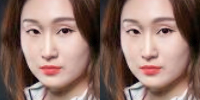

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

img_path = "/content/BeautyGAN_result.png"
img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100)) #사이즈를 작게!


img_without_alpha = img[:,:,:3]

def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

final_img = concat_tile([[img, img_without_alpha]])

cv2.imwrite('/content/input2_without_alpha.png', img_without_alpha)

cv2_imshow(final_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
!python ./eval.py -i configs/srgan.json resources/pretrained/srgan.pth "/content/input2_without_alpha.png"

Running on GPU 0
/content/srgan/models/weight_inits.py:101: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  _get_init_fn(weight_init)(m.weight.data)
/content/srgan/models/weight_inits.py:103: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  _get_init_fn(bias_init)(m.bias.data)
/content/srgan/models/weight_inits.py:101: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  _get_init_fn(weight_init)(m.weight.data)
Restored checkpoint from resources/pretrained/srgan.pth
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necess

In [ ]:
original_img = cv2.imread('/content/input2_without_alpha.png')
srgan_super_resolved_img = cv2.imread('/content/input2_without_alpha_pred.png')

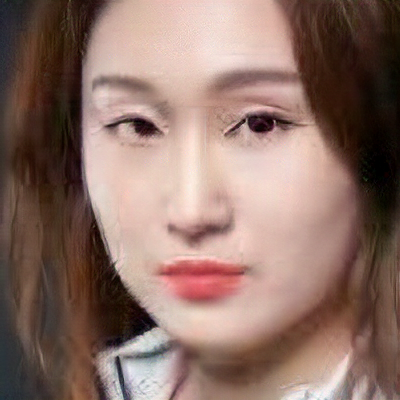

In [ ]:
cv2_imshow(srgan_super_resolved_img)